In [1]:
import tensorflow as tf

# get the GPU device
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  print('No GPU found')

Found GPU at: /device:GPU:0


In [2]:
import torch

if torch.cuda.is_available():

  # tell PyTorch to use the GPU
  device = torch.device('cuda')

  print("There are %d GPUs available" %torch.cuda.device_count())
  print('Use GPU:', torch.cuda.get_device_name(0))

There are 1 GPUs available
Use GPU: Tesla P100-PCIE-16GB


In [3]:
! pip install Transformers

     |████████████████████████████████| 645kB 9.5MB/s 
     |████████████████████████████████| 1.1MB 31.8MB/s 
     |████████████████████████████████| 3.8MB 358kB/s 
     |████████████████████████████████| 890kB 60.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f45b77e0f37fb7a3f22799d6cfe9f6315ccb773609c7550ab7518d7b0f94a3a2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Loading the `Cola Dataset`

In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=9181bceed75eb201f7577b311897dd6663585c55ca1f01147560180a6ccf4a0d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import os
import wget

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')
  #!wget url

for dirname, _, filenames in os.walk('./'):
  for filename in filenames:
    if 'cola' in filename:
      print(os.path.join(dirname, filename))

./cola_public_1.1.zip


In [6]:
# unzip the data
if not os.path.exists('./cola_public_1.1/'):
  !unzip ./cola_public_1.1.zip

Archive:  ./cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [7]:
import pandas as pd
df = pd.read_csv('./cola_public/tokenized/in_domain_train.tsv', sep='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print(df.shape)
df.sample(10)

(8551, 4)


,sentence_source,label,label_notes,sentence
4119,ks08,1,NaN,we know the defendants seem eager to testify a...
3674,ks08,1,NaN,his friend kicked a ball .
3499,ks08,1,NaN,visiting relatives can be boring .
239,cj99,1,NaN,he ate so much that he got sick .
145,cj99,0,*,"it is important for the more you to eat , the ..."
415,bc01,1,NaN,john believes that he is sick .
4014,ks08,1,NaN,the monkey seems despondent .
3750,ks08,1,NaN,thunder frightens the dog .
1481,r-67,1,NaN,it is not true that it was obvious that it wou...
4799,ks08,1,NaN,which book by his father did he read ?


We care about `sentence` and `label`
`label` = 0 , means not grammatically not acceptable
`label` = 1, means grammatrically acceptable

In [8]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
7829,he replied his answer .,0
2245,janet broke at the bread .,0
1221,the money which i am discussing the claim that...,0
5125,which book he read the book was that one .,0
7791,what i arranged for jenny was to be present .,0


In [0]:
# get the list of sentences and their lables

sentences = df.sentence.values
labels = df.label.values

## Using BERT tokenizer
we need to use Bert tokenizer before feeding to BERT

In [10]:
from transformers import BertTokenizer

print('Loading Bert tokenizer.....')
# use the uncased pretrained version of the BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading Bert tokenizer.....


In [11]:
# Apply to one sentence and see
print('original sentence', sentences[0])
print('tokenized', tokenizer.tokenize(sentences[0]))

# sentence mapped to token ids
print('Token ids: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

original sentence our friends wo n't buy this analysis , let alone the next one we propose .
tokenized ['our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token ids:  [2256, 2814, 24185, 1050, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


The above can be done using `tokenizer.encode(sentences[0])`

In [12]:
print(sentences[0])
tokenizer.encode(sentences[0])

our friends wo n't buy this analysis , let alone the next one we propose .


[101,
 2256,
 2814,
 24185,
 1050,
 1005,
 1056,
 4965,
 2023,
 4106,
 1010,
 2292,
 2894,
 1996,
 2279,
 2028,
 2057,
 16599,
 1012,
 102]

## Tokenize Dataset

In [13]:
# maximum sentence length for padding and truncating

max_len = 0
for sent in sentences:
  # tokenize the text and add the '[CLS]' and '[SEP] tokens
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # update the max_len
  max_len = max(max_len, len(input_ids))

print('Max sentence length', max_len)

Max sentence length 47


In case there are some bigger sentences in text, maximum lenght will be set as `64` instead of `47`

Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.
  * Mask: 1, means real token
  * Mask: 0, mean padded token

6. It returns a dictionary of input_ids, token_type_ids and the attention_mask

In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  our friends wo n't buy this analysis , let alone the next one we propose .
Token IDs: tensor([  101,  2256,  2814, 24185,  1050,  1005,  1056,  4965,  2023,  4106,
         1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [15]:
tokenizer.encode_plus(sentences[0])

{'input_ids': [101, 2256, 2814, 24185, 1050, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
input_ids

tensor([[ 101, 2256, 2814,  ...,    0,    0,    0],
        [ 101, 2028, 2062,  ...,    0,    0,    0],
        [ 101, 2028, 2062,  ...,    0,    0,    0],
        ...,
        [ 101, 2009, 2003,  ...,    0,    0,    0],
        [ 101, 1045, 2018,  ...,    0,    0,    0],
        [ 101, 2054, 2035,  ...,    0,    0,    0]])

## Training and Validation splits

In [17]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a Tensor Dataset
dataset  = TensorDataset(input_ids, attention_masks, labels)

# create a 90-10 split for train-validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


create an iterator for a dataset using the torch DataLoader class. This helps to save on memory

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# batch size is requires. For fine tuning BERT, author recommends a batch size of 16 or 32
batch_size=32

# Data loader for training dataset
train_dataloader  = DataLoader(
                      train_dataset,
                      batch_size = batch_size,
                      sampler = RandomSampler(train_dataset)
                      )

# Data loader for validation
# the order does not matter and hence we will just read sequentially
validation_dataloader = DataLoader(
                          val_dataset,
                          batch_size = batch_size,
                          sampler = SequentialSampler(val_dataset) # pulls batches sequentially
                            )

## Train Classification model

For this task, 
1. we first want to modify the `pre-trained BERT model` to give outputs for classification
2. and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the **huggingface** pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. **Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task**

Here is the current list of classes provided for fine-tuning:

* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# load the pretrained BERT model with a single linear classification at the top

model = BertForSequenceClassification.from_pretrained(
              'bert-base-uncased', # use the 12 layer BERT model with uncased vocab
              num_labels = 2, # for binary_classification
              output_attentions = False, # whether the model returns attention weights
              output_hidden_states = False, # whether the model outputs all hidden states
        )

# Tell pytorch to run this model on GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Explore all the model parameters by name
Names and dimensions of the weights for:
1. The embedding layer
2. the first of the 12 transformers
3. Output layer

In [20]:
# get the model parameters as a list of tuples
params = list(model.named_parameters())

print('The BERT model has {:} parameters'.format(len(params)))

print('\n--------Embedding layer-------------\n')

for p in params[0:5]:
  #print('{} ------------------------ {}'.format(p[0], str(tuple(p[1].size()))))
  # Using {:<55}  {:>12} is text aligment
  # {:<55}: allocate 55 spaces to the left for the text, so this aligns from the left
  # {:>12}: allocate 12 spaces starting from right, so this aligns from the right
  print('{:<55}  {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n----------First Transformer----------------\n')
for p in params[5:21]:
  #print('{} ------------------------- {}'.format(p[0], str(tuple(p[1].size()))))
  print('{:<55}  {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n-----------------Output Layer--------------------\n')
for p in params[-4:]:
  #print('{} -------------------------{}'.format(p[0], str(tuple(p[1].size()))))
  print('{:<55}  {:>12}'.format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 parameters

--------Embedding layer-------------

bert.embeddings.word_embeddings.weight                   (30522, 768)
bert.embeddings.position_embeddings.weight                 (512, 768)
bert.embeddings.token_type_embeddings.weight                 (2, 768)
bert.embeddings.LayerNorm.weight                               (768,)
bert.embeddings.LayerNorm.bias                                 (768,)

----------First Transformer----------------

bert.encoder.layer.0.attention.self.query.weight           (768, 768)
bert.encoder.layer.0.attention.self.query.bias                 (768,)
bert.encoder.layer.0.attention.self.key.weight             (768, 768)
bert.encoder.layer.0.attention.self.key.bias                   (768,)
bert.encoder.layer.0.attention.self.value.weight           (768, 768)
bert.encoder.layer.0.attention.self.value.bias                 (768,)
bert.encoder.layer.0.attention.output.dense.weight         (768, 768)
bert.encoder.layer.0.attention.output.den

## Optimizer and Learning Rate scheduler

Model is loaded. Now we need to grab the training `hyperparameters` from within the stored model

For the purpose of tuning, it is recommended to choose from the following values based on from Appendix A.3 of the [BERT paper]((https://arxiv.org/pdf/1810.04805.pdf):

>- **Batch Size**: 16, 32
- **Learning Rate(Adam)**: 5e-5, 3e-5, 2e-5
- **Number of epochs**: 2, 4

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/))

In [0]:
# AdamW is a class from the hugging face library
# Adam optimizer with weight decay fix
# the parameters passed to the optmizer are the model parameters

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # initial learning rate
                  eps = 1e-8 # default
)

Define the `scheduler` which handles the 'learning rate decay`.
When training a NN, you want to take large steps initially for the  initial learning decay rate and take progessively smaller steps as we horne in on the optimal value for the weights

In [0]:
from transformers import get_linear_schedule_with_warmup

# number of training epochs
epochs =4

# Total number of training steps = [number of batches]  X [number of epochs]
# this is not the same as the number of training samples

total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
                                          optimizer,
                                          num_warmup_steps = 0, # default value
                                          num_training_steps = total_steps
                                          )

## Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 


**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

define a helper function for accuracy

In [0]:
import numpy as np

# find accuracy of prediction vs labels

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# helper function for elaped time

import time
import datetime

def format_time(elapsed):
  '''
  Takes time in seconds and returns
  a string in hh:mm:ss
  '''
  elapsed_rounded = int(round(elapsed))

  # format in hh:mm:ss
  return str(datetime.timedelta(seconds = elapsed_rounded))

## Kick of training

In [25]:
import numpy as np
import random

seed_val = 42

epochs=4

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats= []

# measure total time take for the whole run
total_t0 = time.time()

# for each epoch
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    # perform one full pass on the training set

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # measure how long the training epoch takes
    t0 = time.time()

    # reset the training loss for this epoch
    total_train_loss = 0

    # put the model in 'train' mode
    model.train()

    # for each batch of the training data
    for step, batch in enumerate(train_dataloader):
        
        # progress update every 40 batches
        if step % 40 == 0 and not step == 0:
          # calculate the elaped time
          elapsed = format_time(time.time() - t0)

          # report progress
          print('Batch: {} of {}.. Elaped time: {:}'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass

        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        loss, logits = model(
                            b_input_ids,
                            attention_mask = b_input_mask,
                            labels = b_labels,
                            token_type_ids = None
                          )
        
        # accumulate the training loss over all batches
        total_train_loss += loss.item()

        # perform backward pass to calculate the gradients
        loss.backward()

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.

        optimizer.step()

        # update learning rate        
        scheduler.step()

    # Calculate the average loss across all batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # put the model in evalaution mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # evaluate validation set for each epoch

    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.

            (loss, logits) = model(
                                  b_input_ids,
                                  attention_mask = b_attention_mask,
                                  labels = b_labels,
                                  token_type_ids = None
                                )
            
        # accumulate the validation loss
        total_eval_loss += loss.item()

        # move the logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids =  b_labels.to('cpu').numpy()

        # calaculate the  accuracy for this batch and accumulate over all batches
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('Average Accuracy for this validation run is {:.2f}'.format(avg_val_accuracy))

    # calculate the average loss across all batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # measure time taken
    validation_time = format_time(time.time() - t0)

    print('Average validation loss: {:.2f}'.format(avg_val_loss))
    print('Time taken for validation {}'.format(validation_time))

    training_stats.append(
                {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time   
               }
                )
    
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Batch: 40 of 241.. Elaped time: 0:00:08
Batch: 80 of 241.. Elaped time: 0:00:16
Batch: 120 of 241.. Elaped time: 0:00:24
Batch: 160 of 241.. Elaped time: 0:00:32
Batch: 200 of 241.. Elaped time: 0:00:40
Batch: 240 of 241.. Elaped time: 0:00:48

  Average training loss: 0.50
  Training epoch took: 0:00:48

Running Validation...
Average Accuracy for this validation run is 0.82
Average validation loss: 0.41
Time taken for validation 0:00:02

======== Epoch 2 / 4 ========
Training...
Batch: 40 of 241.. Elaped time: 0:00:08
Batch: 80 of 241.. Elaped time: 0:00:16
Batch: 120 of 241.. Elaped time: 0:00:24
Batch: 160 of 241.. Elaped time: 0:00:32
Batch: 200 of 241.. Elaped time: 0:00:39
Batch: 240 of 241.. Elaped time: 0:00:47

  Average training loss: 0.31
  Training epoch took: 0:00:47

Running Validation...
Average Accuracy for this validation run is 0.84
Average validation loss: 0.39
Time taken for validation 0:00:02

======== Epoch 3 / 4 ========
Training...
Batch: 40 of 241.. Elaped time

## Summary of the training process

In [33]:
import pandas as pd
pd.set_option('precision', 2)

# create a dataframe from the training stats
df_stats =  pd.DataFrame(data = training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.50,0.41,0.82,0:00:48,0:00:02
2,0.31,0.39,0.84,0:00:47,0:00:02
3,0.18,0.51,0.82,0:00:48,0:00:02
4,0.12,0.54,0.84,0:00:48,0:00:02


Training loss is decreasing with every epoch whereas validation loss is increasing. So this means we are training our model too long and is over-fitting
* `Validation loss` is more precise than accuracy because with accuracy, we do not care about exact output value, but just which sides of the threshold it falls on
* If we are predicting the correct answer with lesser confidence, then the `validation loss` will catch thisy, while accuracy will not

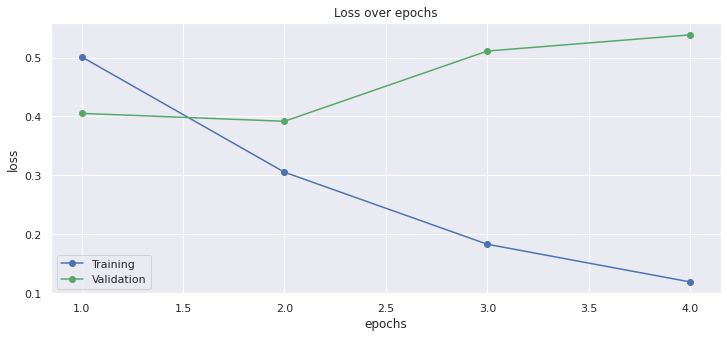

In [40]:
# plot the losses over epochs
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

#plt.rcParams['figure.figsize'] = (12,6)
plt.figure(figsize=(12,5))
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

plt.title('Loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.show()

## Performance on the Test set

* Evaluate prediction using [Matthew's Correlation Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), since this is a metrci wdiely used for COLAB
  * Best score: +1, Worst score: -1

* Repeat the same steps as done for training



### Data preparation for test set

In [42]:
# check for the test data
for dirname, _, filenames in os.walk('./cola_public/'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

./cola_public/README
./cola_public/tokenized/out_of_domain_dev.tsv
./cola_public/tokenized/in_domain_train.tsv
./cola_public/tokenized/in_domain_dev.tsv
./cola_public/raw/out_of_domain_dev.tsv
./cola_public/raw/in_domain_train.tsv
./cola_public/raw/in_domain_dev.tsv


In [49]:
# load the raw version of the test data, as we need to tokenize using Bert tokenizer as we did for training

df_test = pd.read_csv('./cola_public/raw/in_domain_dev.tsv', delimiter='\t', header = None, 
                      names = ['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of sentences', df_test.shape[0])
print('target label distributions\n', df_test['label'].value_counts())

# create list for sentence and labels
sentences = df_test.sentence.values
labels = df_test.label.values

# Tokenize all sentences and map the tokens to their IDs
input_ids = []
attention_masks = []

for sent in sentences:
    # using 'encode_plus' on the BERT tokenizer
    encoded_dict = tokenizer.encode_plus(
                                         sent,
                                         add_special_tokens = True,
                                         max_length = 64,
                                         pad_to_max_length = True,
                                         return_tensors = 'pt',
                                         return_token_type_ids = False,
                                         return_attention_mask = True
                                         )
    
    # add the encoded sentences to the list
    input_ids.append(encoded_dict['input_ids'])

    # add the attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# convert the list into tensors

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.as_tensor(labels)

# set the batch_size
batch_size = 32

# Create the Tensor Dataset and then feed that in batches to the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks, labels)

# use a sequential sampler to sample from the TensorDatset
prediction_sampler = SequentialSampler(prediction_data)

# use the DataLoader
prediction_dataloader = DataLoader(prediction_data, sampler =prediction_sampler, batch_size = batch_size)

Number of sentences 527
target label distributions
 1    365
0    162
Name: label, dtype: int64


### Evaluation on the test data

In [58]:
# prediction on the test data
print('Predicting labels for {} test sentences'.format(len(input_ids)))

# put the model in eval mode
model.eval()

# tracking variables
predictions, true_labels = [], []

t0 = time.time()

# predict
for batch in prediction_dataloader:
    # add batch to gpu
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels

    batch = tuple(t.to(device) for t in batch)

    # unpack the inputs from the data loader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction

    with torch.no_grad():
      # forward pass and logit prediction
      (loss, logits) = model(
                            b_input_ids,
                            attention_mask = b_input_mask,
                            labels = b_labels,
                            token_type_ids = None
                            )
      
    # move the logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    labels_ids = b_labels.to('cpu').numpy()

    # store the predictions and true labels
    predictions.append(logits)
    true_labels.append(labels_ids)

    

print('prediction done for the test dataset')
print('Time elapsed: {}'.format(format_time(time.time() - t0)))

Predicting labels for 527 test sentences
prediction done for the test dataset
Time elapsed: 0:00:01


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:

In [62]:
print('Positive sample: {} of {}, percent: {:.2f}%'.format(df_test.label.sum(), len(df_test), df_test.label.sum()/ len(df_test) *100))

Positive sample: 365 of 527, percent: 69.26%


`predictions` has 2 columns for the target variable: `0` and `1`


In [65]:
predictions[0].shape

(32, 2)

In [74]:
# for first batch
predictions[0]

array([[-2.8889222 ,  2.474354  ],
       [-3.0595424 ,  2.186653  ],
       [-2.7811334 ,  2.1930258 ],
       [-2.9911351 ,  2.3691454 ],
       [-1.5605103 ,  1.3465897 ],
       [-2.406904  ,  2.184461  ],
       [-1.718813  ,  0.91929144],
       [-1.662456  ,  0.9477272 ],
       [-2.714778  ,  1.9349779 ],
       [-2.8371122 ,  2.0363214 ],
       [-2.5710945 ,  1.6252381 ],
       [-2.6217153 ,  1.709917  ],
       [-2.8546689 ,  1.8920379 ],
       [-1.7358351 ,  1.0410931 ],
       [-2.6591558 ,  1.838917  ],
       [-2.7687232 ,  1.720714  ],
       [-1.141209  ,  0.45763227],
       [-2.6364357 ,  1.8507507 ],
       [-2.5240486 ,  1.8860533 ],
       [-2.470266  ,  1.7901187 ],
       [-3.108459  ,  2.304896  ],
       [-2.813622  ,  1.9850817 ],
       [-2.6531312 ,  1.9192628 ],
       [-2.456566  ,  2.0414546 ],
       [-2.8342369 ,  2.3708696 ],
       [-3.0742104 ,  2.206515  ],
       [-3.0685074 ,  2.404764  ],
       [-3.1499765 ,  2.3629422 ],
       [ 0.28986952,

In [72]:
# true labels for first batch, there are 17 such batches
true_labels[0]

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [83]:
from sklearn.metrics import matthews_corrcoef

matthews_set =[]

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# for each batch
# len(true_labels) is the number of batches

for i in range(len(true_labels)):
    
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.

    pred_labels_batch_i = np.argmax(predictions[i], axis=1).flatten()

    # calculate and store the corrcoef for this batch
    matthews  = matthews_corrcoef(true_labels[i], pred_labels_batch_i)
    matthews_set.append(matthews)

print('\nMatthews correlation coefficient for the entire test set')
matthews_set

Calculating Matthews Corr. Coef. for each batch...

Matthews correlation coefficient for the entire test set


[0.3110855084191276,
 0.37084202772044256,
 0.41184152944810126,
 0.539791896359413,
 0.6777749493656265,
 0.4732058754737091,
 0.49382916465843113,
 0.777878154009821,
 0.5691908489504616,
 0.20672455764868078,
 0.5465943944999485,
 0.6695340634119862,
 0.3578300267477955,
 0.8958064164776167,
 0.746031746031746,
 0.6457765999379483,
 0.7071067811865475]

In [77]:
predictions[0]

array([[-2.8889222 ,  2.474354  ],
       [-3.0595424 ,  2.186653  ],
       [-2.7811334 ,  2.1930258 ],
       [-2.9911351 ,  2.3691454 ],
       [-1.5605103 ,  1.3465897 ],
       [-2.406904  ,  2.184461  ],
       [-1.718813  ,  0.91929144],
       [-1.662456  ,  0.9477272 ],
       [-2.714778  ,  1.9349779 ],
       [-2.8371122 ,  2.0363214 ],
       [-2.5710945 ,  1.6252381 ],
       [-2.6217153 ,  1.709917  ],
       [-2.8546689 ,  1.8920379 ],
       [-1.7358351 ,  1.0410931 ],
       [-2.6591558 ,  1.838917  ],
       [-2.7687232 ,  1.720714  ],
       [-1.141209  ,  0.45763227],
       [-2.6364357 ,  1.8507507 ],
       [-2.5240486 ,  1.8860533 ],
       [-2.470266  ,  1.7901187 ],
       [-3.108459  ,  2.304896  ],
       [-2.813622  ,  1.9850817 ],
       [-2.6531312 ,  1.9192628 ],
       [-2.456566  ,  2.0414546 ],
       [-2.8342369 ,  2.3708696 ],
       [-3.0742104 ,  2.206515  ],
       [-3.0685074 ,  2.404764  ],
       [-3.1499765 ,  2.3629422 ],
       [ 0.28986952,

In [78]:
np.argmax(predictions[0], axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

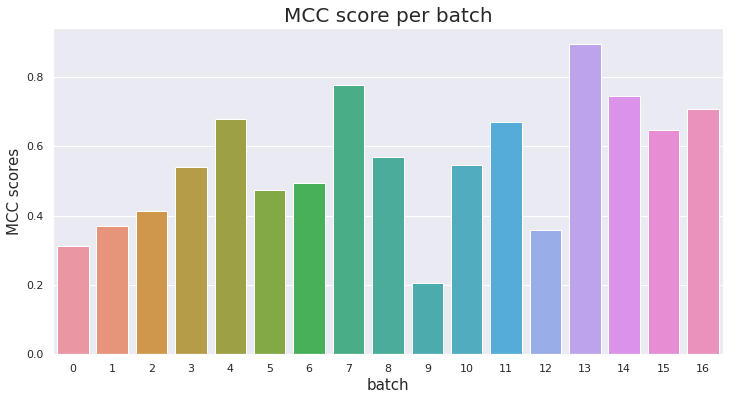

In [93]:
# Create a bar plot showing the MCC scores for each batch of the test samples

plt.figure(figsize=(12,6))
sns.barplot(x = np.arange(len(matthews_set)), y = matthews_set)
plt.title('MCC score per batch', fontsize=20)
plt.xlabel('batch', fontsize=15)
plt.ylabel('MCC scores', fontsize=15)
plt.show()

In [100]:
print('Mean MCC score is : {:.2f}'.format(np.mean(matthews_set)))

Mean MCC score is : 0.55
